# Analysis

In [2]:
# library(tidyverse)
library(dplyr)
library(tidyr)
library(ggplot2)
library(readxl)
library(sf)
library(tmap)
library(brms)

## Background

In [3]:
dat_cue <-
    read_xlsx("../../../data/primary/carbon_use_efficiency/41598_2019_42145_MOESM2_ESM.xlsx",
        .name_repair = "unique"
    ) %>%
    select(No_Wj,
        Author,
        # Site,
        lat = Latitude,
        lon = longitude,
        CUE,
        PFT = `PFT...7`,
        Temp = "Temperature(℃)"
    ) %>%
    # fill in and simplify author names
    fill(Author, .direction = "down") %>%
    mutate(AuthorID = as.numeric(as.factor(Author))) %>%
    # center temperature at 20 deg C
    mutate(
        Temp = as.numeric(Temp),
        Temp_centered = Temp - 20
    ) %>%
    # remove incomplete data
    filter(!is.na(Temp_centered))

New names:
• `PFT` -> `PFT...6`
• `PFT` -> `PFT...7`
• `Substrate` -> `Substrate...12`
• `Substrate` -> `Substrate...15`
• `Substrate` -> `Substrate...16`
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Temp = as.numeric(Temp)`.
Caused by warning:
! NAs introduced by coercion”


Currently, the temperature-dependent carbon use efficiency (CUE) function we used is $$
\text{CUE} = \text{CUE}_\text{ref} + \text{CUE}_T \left(T - T_\text{ae-ref} \right) \,,
$$ where $T$ is temperature ($^\circ$C), $\text{CUE}_\text{ref}$ is the CUE at reference
temperature $T_\text{ae-ref}$ (i.e., centered intercept), and $\text{CUE}_T$ is the
temperature-dependence slope. This equation came from @abramoff_millennial_2018, who
cited @xu-ri_terrestrial_2008, who then cited @Devevre2000 and used their empirical
estimates. In @Devevre2000, CUE came from a single rice paddy study:

> by soil microorganisms during rice straw decomposition was determined in a rice paddy
> soil, under aerobic and anaerobic (flooded) conditions at different temperatures (5,
> 15, and 25°C)

The latest global study I could find is @Qiao2019. Mostly from US and Europe and not a
lot of tropical studies (see map below; there are some misplaced coordinates but I think
they are placeholder for missing data), but seems to be the most extensive to date.
Their model is also identical to ours so should be easy to adapt.

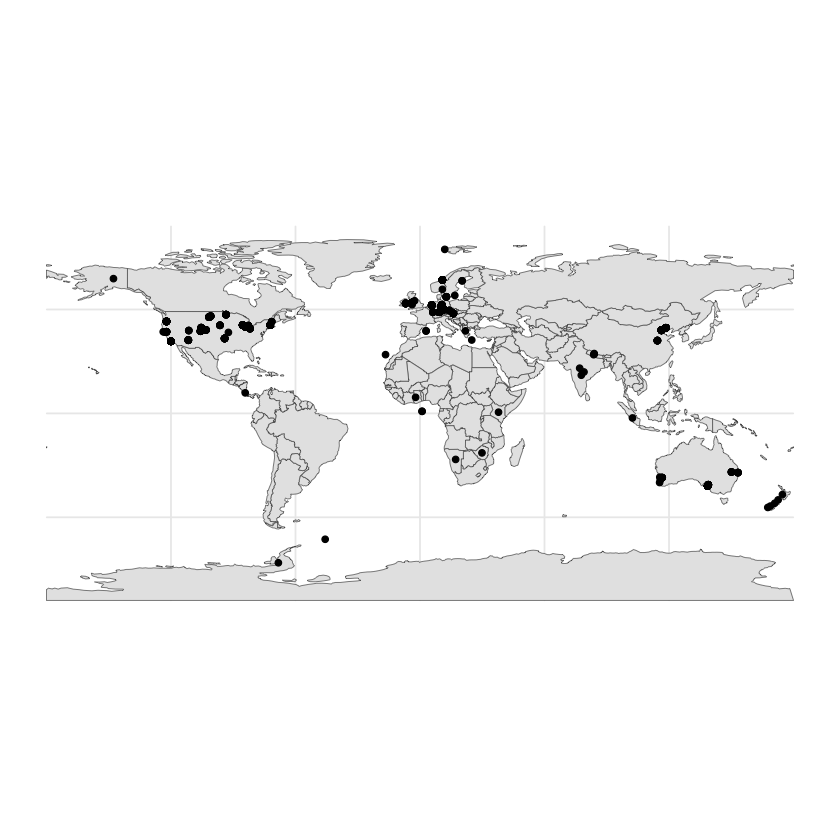

In [4]:
data("World")

dat_sf <-
    dat_cue %>%
    st_as_sf(
        coords = c("lon", "lat"),
        crs = st_crs(World)
    )

ggplot() +
    geom_sf(data = World) +
    geom_sf(data = dat_sf) +
    theme_minimal()

@Qiao2019 performed curve fitting and published their parameter estimates. However, they
fitted a linear regression that could predict CUE out of bound (above 1 or below 0)
under certain temperature. Our goal here is to refit a model on their compiled dataset,
and constrain CUE to be bound between 0 and 1 using a generalised linear regression
(GLM).

## Modelling

A beta-distribution GLM with logit link would do this. Our generative model is:

\begin{equation*}
\begin{aligned}
\text{CUE}_{ij} &\sim \text{Beta}\left( \mu_{ij}, \phi \right) \\
\text{logit}
    \left( \mu_{ij} \right) &= \text{CUE}_\text{ref} + \text{CUE}_T
    \left(T_{ij} - T_\text{ae-ref} \right) + \epsilon_j \,,
\end{aligned}
\end{equation*}

where $\mu_{ij}$ is the linear predictor of CUE for observation $i$ in study $j$. The
dataset contains multiple CUE values from the same study, so I controlled for
non-independence within study using a random intercept term $\epsilon_j$.

There are covariates that could potentially be included, such as biome and length of
incubation. I have left them out for simplicity here, and because biome contains missing
data. If needed, we could revisit these covariates.

The model was fitted with Bayesian inference using the `brms` package in `R`.

In [5]:
if (! dir.exists("out")){
dir.create("out")
}

m <- brm(
    CUE ~ 1 + Temp_centered + (1 | Author),
    data = dat_cue,
    family = Beta(),
    prior =
        prior(normal(0, 0.5), ub = 0, class = b),
    warmup = 3000,
    iter = 4000,
    cores = 4,
    file = "out/model_cue",
    file_refit = "on_change"
)

In [6]:
# Show the model summary
summary(m)

 Family: beta 
  Links: mu = logit; phi = identity 
Formula: CUE ~ 1 + Temp_centered + (1 | Author) 
   Data: dat_cue (Number of observations: 693) 
  Draws: 4 chains, each with iter = 4000; warmup = 3000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~Author (Number of levels: 46) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.91      0.10     0.73     1.13 1.01      514      660

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         0.09      0.14    -0.18     0.36 1.01      395      678
Temp_centered    -0.04      0.01    -0.06    -0.02 1.00     1358     1708

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi    12.42      0.71    11.07    13.86 1.00     3364     2749

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and

## Results

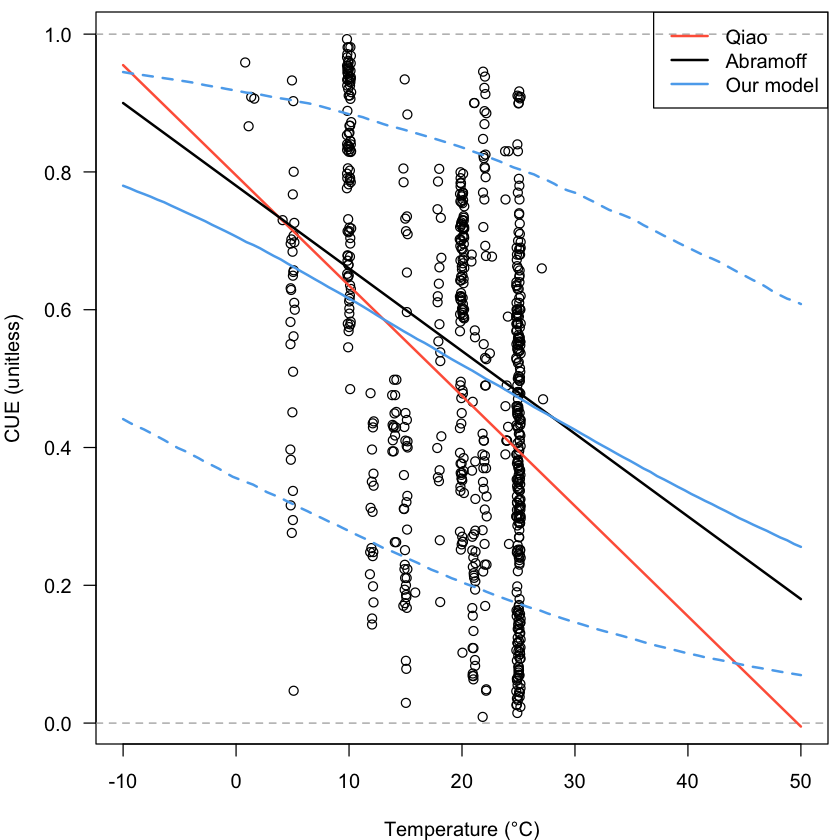

In [7]:
# counterfactual data
newdat <-
    data.frame(
        Temp = seq(-10, 50, length.out = 100),
        Author = NA
    ) %>%
    mutate(Temp_centered = Temp - 20)

# fitted line from our model
cue_hat <-
    fitted(
        m,
        newdata = newdat,
        scale = "response",
        robust = TRUE,
        probs = c(0.05, 0.95),
        allow_new_levels = TRUE
    )

# fitted line from Qiao et al. (2019)
cue_hat_qiao <- 0.475 - 0.016 * newdat$Temp_centered

# fitted line from Abramoff et al. (2018)
cue_hat_abramoff <- 0.6 - 0.012 * (newdat$Temp - 15)

# plot
par(mar = c(4, 4, 0.5, 0.5), las = 1)
with(dat_cue, plot(
    jitter(Temp, 2), CUE,
    xlim = c(-10, 50),
    xlab = "Temperature (\u00B0C)",
    ylab = "CUE (unitless)"
))
abline(h = c(0, 1), col = "darkgrey", lty = 2)
lines(newdat$Temp, cue_hat_qiao,
    col = "tomato",
    lwd = 2
)
lines(newdat$Temp, cue_hat_abramoff,
    col = "black",
    lwd = 2
)
lines(newdat$Temp, cue_hat[, "Estimate"],
    col = "steelblue2",
    lwd = 2
)
lines(newdat$Temp, cue_hat[, "Q5"],
    col = "steelblue2",
    lwd = 2, lty = 2
)
lines(newdat$Temp, cue_hat[, "Q95"],
    col = "steelblue2",
    lwd = 2, lty = 2
)
legend("topright",
    lwd = 2,
    col = c("tomato", "black", "steelblue2"),
    legend = c("Qiao", "Abramoff", "Our model")
)

## References